In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial
import optax
from field import lin_interp, cic_ma, gradient

In [2]:
@jax.jit
def step(
        params,
        grid_star : jnp.ndarray,
        dx : float,
        rate : float,
        iteration : float):
    
    pos = params["pos"]
    weight = params["weight"]
    grid_size = grid_star.shape[0]
    N = pos.shape[1]
        
    grid = cic_ma(pos, weight, grid_size, dx)

    # define the desired change 
    field = (grid - grid_star)

    # get the gradient grid
    grad_field = gradient(field, dx)

    grad_pos_x = lin_interp(
        pos, 
        grad_field[0])
    
    grad_pos_y = lin_interp(
        pos, 
        grad_field[1])
    
    grad_pos_z = lin_interp(
        pos, 
        grad_field[2])
    
    grad_pos = jnp.stack([
        grad_pos_x, grad_pos_y, grad_pos_z])
    
    factor = 1.0 / (iteration*0.1+1)
    factor = jax.random.uniform(jax.random.PRNGKey(iteration), (N, ))
    params["pos"] = pos + rate * factor * grad_pos

    return params


In [3]:
def mse(params, grid_star : jnp.ndarray):
    pos = params["pos"]
    weight = params["weight"]
    grid_size = grid_star.shape[0]
        
    grid = cic_ma(pos, weight, grid_size, 1)

    return jnp.mean((grid_star - grid)**2)

def optimize(
        params, 
        grid_star : jnp.ndarray, 
        dx : float, 
        n_steps : int,
        rate : float) -> jnp.ndarray:

    for i in range(n_steps):
        params = step(params, grid_star, dx, rate, i)
        print(f"mse : {mse(params, grid_star)}")

    return params


In [4]:
grid_size = 32
N = grid_size ** 3
dx = 1

key = jax.random.key(0)

key_pos, key_weight = jax.random.split(key)

# create particles
pos = jax.random.uniform(key_pos, (3, N))
# weight = jax.random.uniform(key_weight, (N,)) / N * (grid_size ** 3)
weight = jnp.ones((N, )) / N * (grid_size ** 3)

# assign particles 
grid_star = cic_ma(pos, weight, grid_size, dx)

# no matter what N or grid_size is -> ~0.5
print(jnp.mean(grid_star))

1.0


In [8]:
key = jax.random.key(1)

key_pos, key_weight = jax.random.split(key)

# distribute evenly across grid
pos = jax.random.uniform(key_pos, (3, N)) 
# weight = jax.random.uniform(key_weight, (N, )) / N * (grid_size ** 3)
weight = jnp.ones((N, )) / N * (grid_size ** 3)

params_init = {
    'pos' : pos,
    'weight' : weight}

params = optimize(params_init, grid_star, dx, 1000, 0.001)

mse : 1.730605125427246
mse : 1.6328613758087158
mse : 1.5575225353240967
mse : 1.4976532459259033
mse : 1.4346380233764648
mse : 1.384422779083252
mse : 1.3378334045410156
mse : 1.2942333221435547
mse : 1.2647747993469238
mse : 1.2345571517944336
mse : 1.2136766910552979
mse : 1.183915138244629
mse : 1.1647628545761108
mse : 1.1414954662322998
mse : 1.1197575330734253
mse : 1.1014894247055054
mse : 1.0838518142700195
mse : 1.0725120306015015
mse : 1.0562801361083984
mse : 1.043947696685791
mse : 1.0346035957336426
mse : 1.024207592010498
mse : 1.0096365213394165
mse : 1.00687837600708
mse : 0.9946741461753845
mse : 0.9853053689002991
mse : 0.9723197817802429
mse : 0.9714175462722778
mse : 0.9568865299224854
mse : 0.9556607007980347
mse : 0.9470142126083374
mse : 0.945972204208374
mse : 0.9415957927703857
mse : 0.9377444982528687
mse : 0.9328733682632446
mse : 0.9244133234024048
mse : 0.9273901581764221
mse : 0.9208892583847046
mse : 0.9160828590393066
mse : 0.9112734794616699
mse : 0.

[[0.16077855 0.78070414 0.11816335 ... 0.66308904 0.26831895 0.7179464 ]
 [0.42471164 0.06080424 0.536696   ... 0.03123872 0.5625632  0.20082965]
 [0.11715572 0.42836893 0.5134359  ... 0.21872357 0.38793957 0.21088833]]


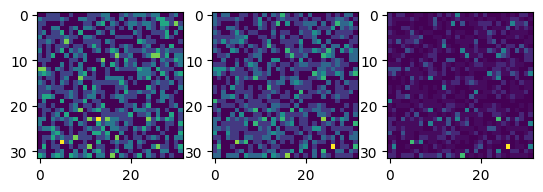

In [135]:
print(params["pos"])

grid = cic_ma(params["pos"], params["weight"], grid_size, 0.1)

# define the desired change 
field = (grid - grid_star)**2


# plot side by side
plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(grid_star[grid_size // 2, :, :])
plt.subplot(1, 3, 2)
plt.imshow(grid[grid_size // 2, :, :])
plt.subplot(1, 3, 3)
plt.imshow(field[grid_size // 2, :, :])
plt.show()